<a href="https://colab.research.google.com/github/dineshRaja29/SupportVectorMachine/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<font color='green'><b>INTRODUCTION </b></font>

<ol>
    <li><strong>Applying SVM on these feature sets</strong>
        <ul>
            <li>Review text, preprocessed one converted into vectors using BOW</li>
            <li>Review text, preprocessed one converted into vectors using TF-IDF</li>
            <li>Review text, preprocessed one converted into vectors using AVG W2V</li>
            <li>Review text, preprocessed one converted into vectors using TFIDF W2V</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>Exploring 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>While working with linear kernel, we use SGDClassifier with hinge loss because it is computationally less expensive.</li>
    <li>Performance Metric we have used is AUC
        score, for probability scores we have use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when we are working with RBF kernel then it's better to reduce
the number of dimensions. [min_df = 10, max_features = 500, and 40k points].</li>                
        </ul>
    </li>
    <br>

##<font color='green'><b>DATASET DETAILS </b></font>




Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

##<font color='green'><b>PREPROCESSING</b></font>

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from matplotlib.colors import Normalize
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

In [ ]:
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [ ]:
display['COUNT(*)'].sum()

393063

###<font color='green'><b>Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

###<font color='green'><b>DATA NORMALIZATION </b></font>


1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming<br>


In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2540.20it/s]


In [ ]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [ ]:
# Confusion matrix print function 
def ConfusionMatrixPrint(cm):
  class_label = ["negative", "positive"]
  df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
  sns.heatmap(df_cm, annot = True, fmt = "d")
  plt.title("Confusiion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()
  
def ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr):
  plt.figure()
  plt.plot(fpr, tpr,label='Test ROC curve' ,
           color='darkorange', linestyle=':', linewidth=4)

  plt.plot(fpr_tr, tpr_tr,label='Train ROC curve',
           color='navy', linestyle=':', linewidth=4)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC CURVE ')
  plt.legend(loc="lower right")
  plt.show()

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [ ]:
X = preprocessed_reviews
y = final['Score']
print(len(X))
print(len(y))
print(y.value_counts())
# Random Splitting of data using train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

87773
87773
1    73592
0    14181
Name: Score, dtype: int64



##<font color='green'><b>Linear SVM

###<font color='green'><b>BOW

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
#learning vocabulary 
vectorizer =  CountVectorizer()
vectorizer.fit(X_tr)
train_data = vectorizer.transform(X_tr)
svc = linear_model.SGDClassifier(loss = 'hinge')
val = [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**2, 10**3, 10**4]
param_grid =  { 'alpha' : [float(i) for i in val],
               'penalty': ['l1', 'l2']}

print("Parameter ranges are \n",param_grid)
clf = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(train_data, y_tr)
print('Best Penalty:', clf.best_estimator_.get_params()['penalty'])
print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])

Parameter ranges are 
 {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 100.0, 1000.0, 10000.0], 'penalty': ['l1', 'l2']}
Best Penalty: l2
Best Alpha: 0.001


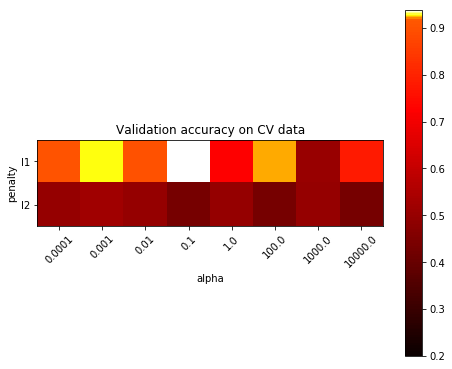

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on CV data')
plt.show()

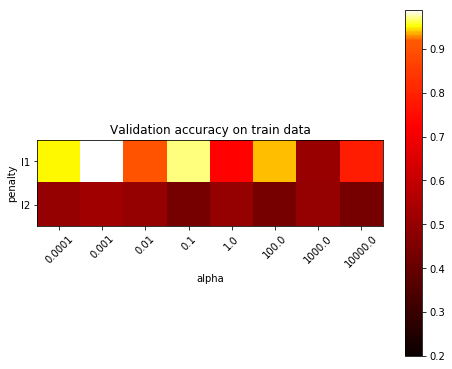

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))



 Train Score **

[[0.95220297 0.9884883  0.90436692 0.97079296 0.72969495 0.94058122
  0.50764449 0.78849942]
 [0.5        0.52386032 0.5        0.43380807 0.5        0.4338083
  0.5        0.43380696]]

 CV Score **

[[0.90543259 0.92935202 0.89769717 0.93797531 0.72871881 0.92426268
  0.50793372 0.78167963]
 [0.5        0.52258884 0.5        0.43338546 0.5        0.43338546
  0.5        0.43338424]]


#### Optimal Hyperparameter  is L2 penalty with value 0.001 

In [ ]:
vectorizer =  CountVectorizer()
vectorizer.fit(X_tr)
train_data = vectorizer.transform(X_tr)
test_dtm = vectorizer.transform(X_test)


In [ ]:
svc_base = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 0.001)
svc = CalibratedClassifierCV(svc_base, cv=3)
svc.fit(train_data,y_tr)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                       

Confusion Matrix of train data 



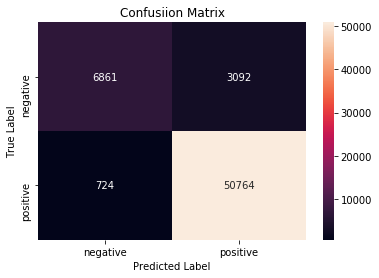

Confusion Matrix of test data 



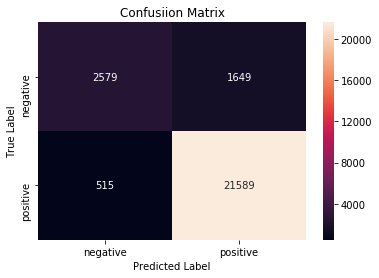

**** TEST AUC ***  0.7690601511869066
**** TRAIN AUC *****  0.7908384300947204


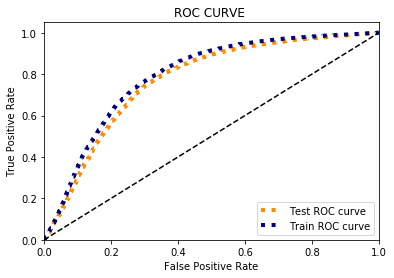

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(train_data)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(train_data))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

#### The feature Importance, i.e., printing top 10 positive and printing top 10 negative features

In [ ]:
svc = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 0.001)
svc.fit(train_data,y_tr)
feature_names = vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(svc.coef_[0], feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10+ 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s"% (coef_1, fn_1, coef_2, fn_2))

	-0.9798	worst          		0.5719	delicious      
	-0.8636	disappointing  		0.5602	perfect        
	-0.7695	terrible       		0.5382	excellent      
	-0.7648	disappointment 		0.5312	amazing        
	-0.7648	threw          		0.5091	best           
	-0.7369	horrible       		0.4882	complaint      
	-0.7137	awful          		0.4870	wonderful      
	-0.6846	disappointed   		0.4789	great          
	-0.6381	stale          		0.4591	yummy          
	-0.6242	rip            		0.4487	awesome        


###<font color='green'><b>Tf-Idf





In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
#learning vocabulary 
vectorizer =  TfidfVectorizer()
vectorizer.fit(X_tr)
train_data = vectorizer.transform(X_tr)
svc = linear_model.SGDClassifier(loss = 'hinge')
val = [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**2, 10**3, 10**4]
param_grid =  { 'alpha' : [float(i) for i in val],
               'penalty': ['l1', 'l2']}

print("Parameter ranges are \n",param_grid)
clf = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(train_data, y_tr)
print('Best Penalty:', clf.best_estimator_.get_params()['penalty'])
print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])

Parameter ranges are 
 {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 100.0, 1000.0, 10000.0], 'penalty': ['l1', 'l2']}
Best Penalty: l2
Best Alpha: 0.0001


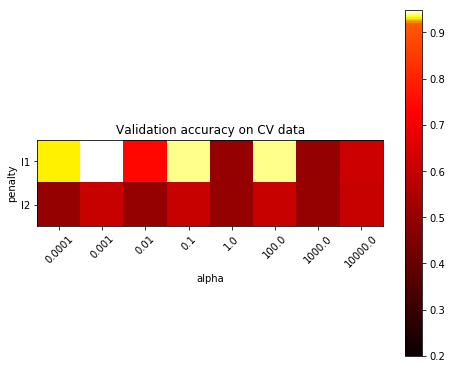

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on CV data')
plt.show()

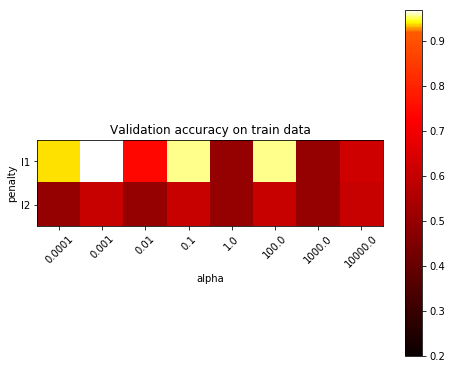

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))



 Train Score **

[[0.93939945 0.96841033 0.7449647  0.957086   0.5        0.95713412
  0.5        0.6231179 ]
 [0.5        0.60877053 0.5        0.60877053 0.5        0.60877053
  0.5        0.60877053]]

 CV Score **

[[0.93264566 0.9481994  0.74482306 0.94166312 0.5        0.94177499
  0.5        0.62005627]
 [0.5        0.60617725 0.5        0.60617725 0.5        0.60617725
  0.5        0.60617725]]


#### Optimal Hyperparameter  is L2 penalty with value 0.0001 

In [ ]:
vectorizer =  CountVectorizer()
vectorizer.fit(X_tr)
train_data = vectorizer.transform(X_tr)
test_dtm = vectorizer.transform(X_test)


In [ ]:
svc_base = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 0.0001)
svc = CalibratedClassifierCV(svc_base, cv=3)
svc.fit(train_data,y_tr)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                      

Confusion Matrix of train data 



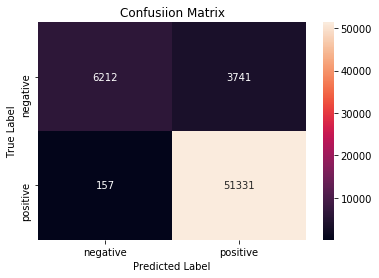

Confusion Matrix of test data 



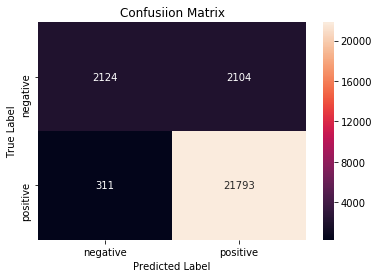

**** TEST AUC ***  0.8560769939883397
**** TRAIN AUC *****  0.906636899417005


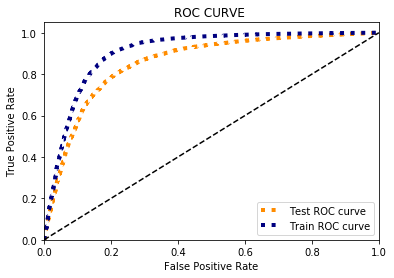

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(train_data)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(train_data))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

#### The feature Importance, i.e., printing top 10 positive and printing top 10 negative features

In [ ]:
svc = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 0.001)
svc.fit(train_data,y_tr)
feature_names = vectorizer.get_feature_names()
# print(svc.coef_[0])
coefs_with_fns = sorted(zip(svc.coef_[0], feature_names))
# print(coefs_with_fns)
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10+ 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s"% (coef_1, fn_1, coef_2, fn_2))

	-0.9872	worst          		0.5695	delicious      
	-0.8679	disappointing  		0.5468	perfect        
	-0.7767	terrible       		0.5446	excellent      
	-0.7692	threw          		0.5131	amazing        
	-0.7670	disappointment 		0.4914	complaint      
	-0.7409	horrible       		0.4893	great          
	-0.7127	awful          		0.4871	wonderful      
	-0.7008	disappointed   		0.4806	best           
	-0.6357	stale          		0.4480	yummy          
	-0.6260	rip            		0.4394	loves          


###<font color='green'><b>Avg W2V

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
X_tr_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in (training_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_vectors.append(sent_vec)


In [ ]:
test_words = []
for sentance in X_test:
    test_words.append(sentance.split())

X_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in test_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
svc = linear_model.SGDClassifier(loss = 'hinge')
val = [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**2, 10**3, 10**4]
param_grid =  { 'alpha' : [float(i) for i in val],
               'penalty': ['l1', 'l2']}

print("Parameter ranges are \n",param_grid)
clf = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(X_tr_vectors, y_tr)
print('Best Penalty:', clf.best_estimator_.get_params()['penalty'])
print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])

Parameter ranges are 
 {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 100.0, 1000.0, 10000.0], 'penalty': ['l1', 'l2']}
Best Penalty: l2
Best Alpha: 0.001


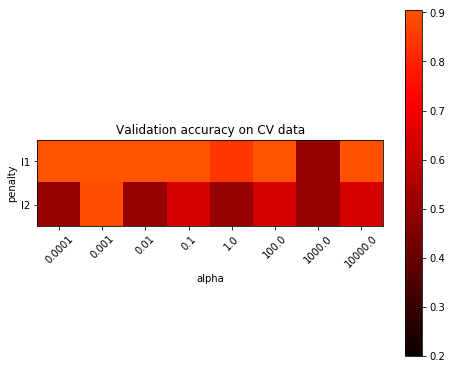

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on CV data')
plt.show()

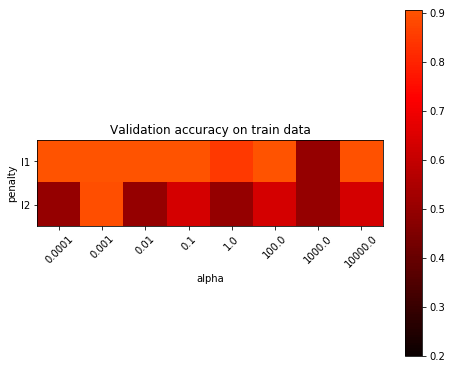

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))



 Train Score **

[[0.90500913 0.90419378 0.90522179 0.9051668  0.8472745  0.90465777
  0.5        0.90294799]
 [0.5        0.89277385 0.5        0.63698885 0.5        0.63698851
  0.5        0.63698851]]

 CV Score **

[[0.90368864 0.90409061 0.90401966 0.90445844 0.84577357 0.90384565
  0.5        0.90237826]
 [0.5        0.89199498 0.5        0.63690419 0.5        0.63690391
  0.5        0.63690391]]


#### Optimal Hyperparameter  is L2 penalty with value 0.001 

In [ ]:
svc_base = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 0.001)
svc = CalibratedClassifierCV(svc_base, cv=3)
svc.fit(X_tr_vectors,y_tr)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                       

Confusion Matrix of train data 



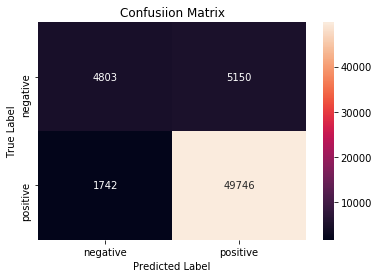

Confusion Matrix of test data 



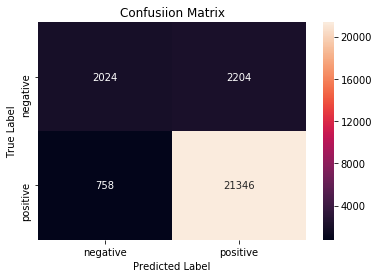

**** TEST AUC ***  0.8328502702970151
**** TRAIN AUC *****  0.8356359033276786


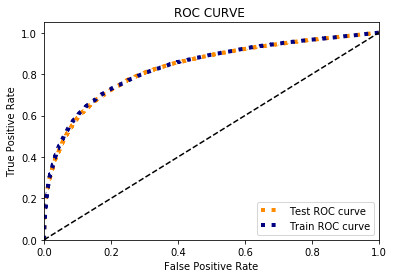

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(X_tr_vectors)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(X_test_vectors)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Tf-Idf W2V

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [ ]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names


In [ ]:
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 61441/61441 [32:40<00:00, 31.34it/s]


In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [14:24<00:00, 30.46it/s]


In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
svc = linear_model.SGDClassifier(loss = 'hinge')
val = [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**2, 10**3, 10**4]
param_grid =  { 'alpha' : [float(i) for i in val],
               'penalty': ['l1', 'l2']}

print("Parameter ranges are \n",param_grid)
clf = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(tfidf_sent_vectors_tr, y_tr)
print('Best Penalty:', clf.best_estimator_.get_params()['penalty'])
print('Best Alpha:', clf.best_estimator_.get_params()['alpha'])



Parameter ranges are 
 {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 100.0, 1000.0, 10000.0], 'penalty': ['l1', 'l2']}
Best Penalty: l2
Best Alpha: 0.01


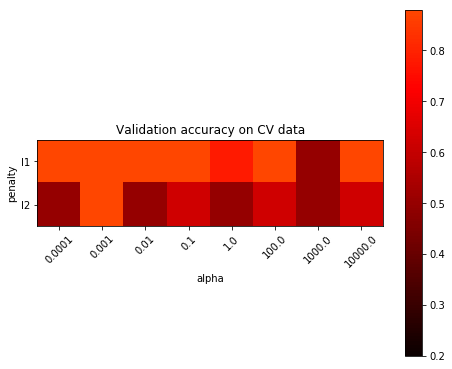

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on CV data')
plt.show()

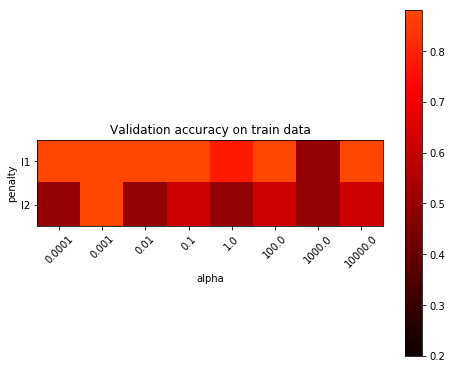

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['penalty']), len(param_grid['alpha']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('alpha')
plt.ylabel('penalty')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'], rotation=45)
plt.yticks(np.arange(len((param_grid['penalty']))), param_grid['penalty'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['penalty']), len(param_grid['alpha'])))



 Train Score **

[[0.8781873  0.87741714 0.87999643 0.88049638 0.78435165 0.88001517
  0.5        0.87831296]
 [0.5        0.87889286 0.5        0.62558908 0.5        0.62558884
  0.5        0.62558884]]

 CV Score **

[[0.87576506 0.8763411  0.87827906 0.87769807 0.78240442 0.87885815
  0.5        0.87702099]
 [0.5        0.87749095 0.5        0.62540099 0.5        0.62540076
  0.5        0.62540076]]


#### Optimal Hyperparameter  is L2 penalty with value 0.01 

In [ ]:
svc_base = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 0.01)
svc = CalibratedClassifierCV(svc_base, cv=3)
svc.fit(tfidf_sent_vectors_tr,y_tr)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=None,
                                                    shuffle=True, tol=0.001,
                                        

Confusion Matrix of train data 



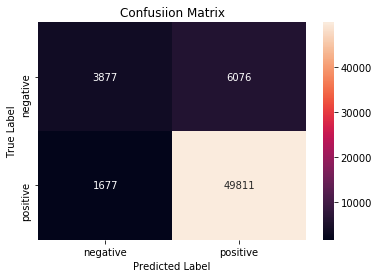

Confusion Matrix of test data 



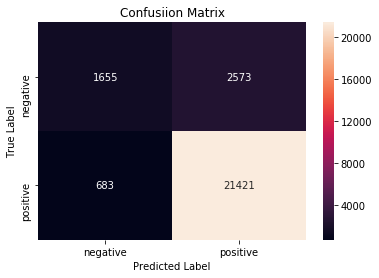

**** TEST AUC ***  0.8214660330232142
**** TRAIN AUC *****  0.8238972032365043


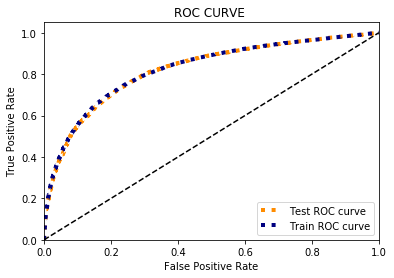

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(tfidf_sent_vectors_tr)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(tfidf_sent_vectors_test)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>RBF SVM

In [ ]:
X = preprocessed_reviews[:20000]
y = final['Score']
y = y[:20000]
print(len(X))
print(len(y))
print(y.value_counts())
# Random Splitting of data using train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

20000
20000
1    16962
0     3038
Name: Score, dtype: int64


###<font color='green'><b>BoW

In [ ]:
vectorizer = CountVectorizer(min_df = 10, max_features = 500)
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
Cs = [2**-1, 2**1, 2**3, 2**5, 2**7]
gammas = [ 2**-3,  2**-1,2**1, 2**3]

param_grid = {'C': Cs, 'gamma' : gammas}
print("parameters are ",param_grid)
clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(X_tr_bow, y_tr)
clf.best_params_
print(clf.best_params_)


parameters are  {'C': [0.5, 2, 8, 32, 128], 'gamma': [0.125, 0.5, 2, 8]}
{'C': 2, 'gamma': 0.125}


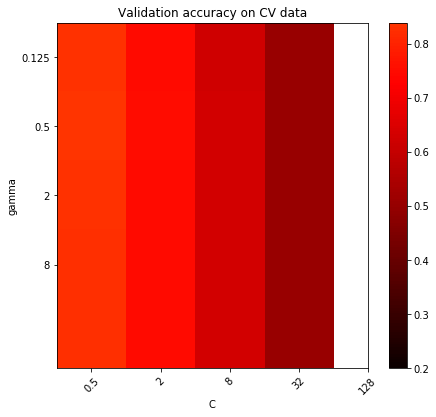

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on CV data')
plt.show()

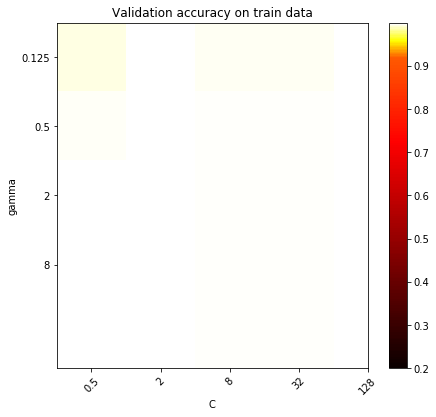

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))



 Train Score **

[[0.99528703 0.99930275 0.99759604 0.99769333]
 [0.99834899 0.99931918 0.99855262 0.99867828]
 [0.99975043 0.99935138 0.99855262 0.99867828]
 [0.9997673  0.99931588 0.99855262 0.99867828]
 [0.99930375 0.99931588 0.99855262 0.99867828]]

 CV Score **

[[0.83405275 0.74881369 0.6267661  0.50895209]
 [0.83849138 0.75145496 0.62998911 0.50895829]
 [0.83149034 0.74856002 0.62998911 0.50895829]
 [0.82956378 0.74857287 0.62998911 0.50895829]
 [0.82600141 0.74857287 0.62998911 0.50895829]]


#### Optimal Hyperparameter  is 'C': 2, 'gamma': 0.125

In [ ]:
svc = svm.SVC(kernel='rbf', C =2 , gamma =0.125, probability=True )
svc.fit(X_tr_bow,y_tr)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.125, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Confusion Matrix of train data 



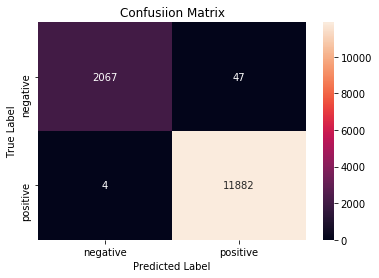

Confusion Matrix of test data 



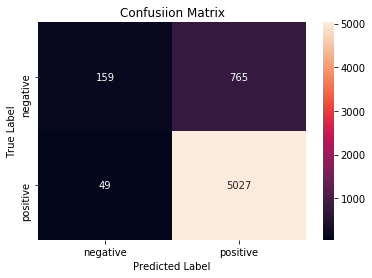

**** TEST AUC ***  0.7869228633856293
**** TRAIN AUC *****  0.19083429126687768


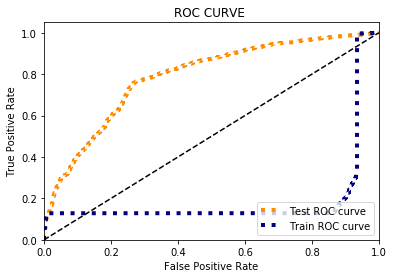

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(X_test_bow)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(X_test_bow))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>Tf-Idf


In [ ]:
vectorizer = TfidfVectorizer(min_df = 10, max_features = 500)
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
Cs = [2**-1, 2**1, 2**3, 2**5, 2**7]
gammas = [ 2**-3,  2**-1,2**1, 2**3]

param_grid = {'C': Cs, 'gamma' : gammas}
print("parameters are ",param_grid)
clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(X_tr_bow, y_tr)
clf.best_params_
print(clf.best_params_)


parameters are  {'C': [0.5, 2, 8, 32, 128], 'gamma': [0.125, 0.5, 2, 8]}
{'C': 8, 'gamma': 2}


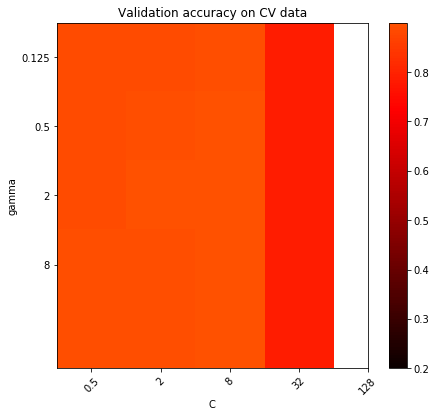

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on CV data')
plt.show()

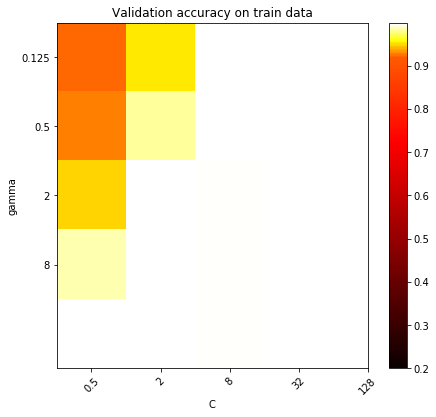

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))



 Train Score **

[[0.92367459 0.95394484 0.99895841 0.99909638]
 [0.9289259  0.98352877 0.99878005 0.99886109]
 [0.94909827 0.99937233 0.99873238 0.99886109]
 [0.98685237 0.99933393 0.99873238 0.99886109]
 [0.99918659 0.99933393 0.99873238 0.99886109]]

 CV Score **

[[0.88796212 0.89059972 0.89414884 0.78866332]
 [0.88931354 0.89450538 0.89981997 0.78885802]
 [0.89023603 0.89791682 0.899996   0.78885802]
 [0.8928302  0.89743066 0.899996   0.78885802]
 [0.89477531 0.89743066 0.899996   0.78885802]]


#### Optimal Hyperparameter  is 'C': 8, 'gamma': 2

In [ ]:
svc = svm.SVC(kernel='rbf', C =8 , gamma =2, probability=True )
svc.fit(X_tr_bow,y_tr)

SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Confusion Matrix of train data 



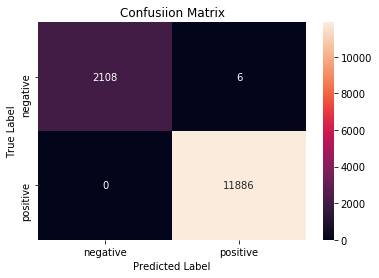

Confusion Matrix of test data 



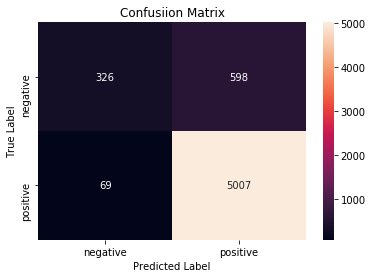

**** TEST AUC ***  0.8162336169871631
**** TRAIN AUC *****  0.13507364427529842


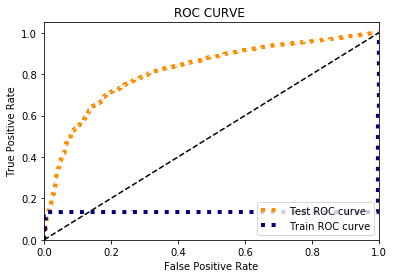

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(X_test_bow)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(X_test_bow))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>AVG W2V



In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
X_tr_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in (training_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_vectors.append(sent_vec)


In [ ]:
test_words = []
for sentance in X_test:
    test_words.append(sentance.split())
X_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in test_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
Cs = [2**-1, 2**1, 2**3, 2**5, 2**7]
gammas = [ 2**-3,  2**-1,2**1, 2**3]

param_grid = {'C': Cs, 'gamma' : gammas}
print("parameters are ",param_grid)
clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(X_tr_vectors, y_tr)
clf.best_params_
print(clf.best_params_)


parameters are  {'C': [0.5, 2, 8, 32, 128], 'gamma': [0.125, 0.5, 2, 8]}
{'C': 8, 'gamma': 0.125}


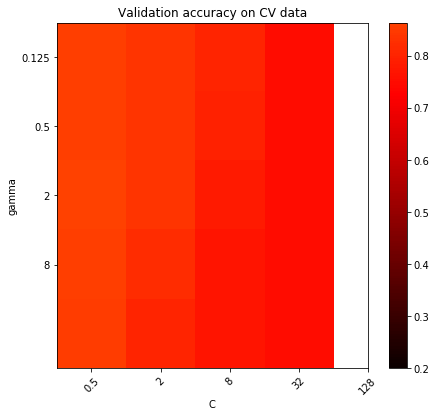

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on CV data')
plt.show()

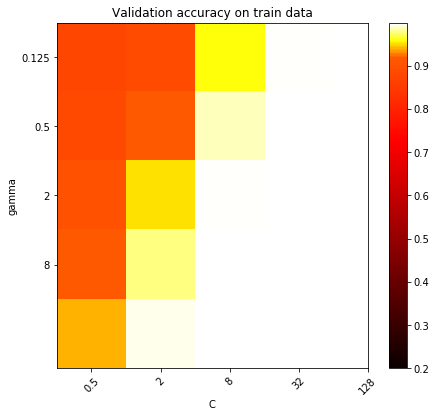

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))



 Train Score **

[[0.87862769 0.88926718 0.96035081 0.99873972]
 [0.88381357 0.91904793 0.98837966 0.99887673]
 [0.89949719 0.95220444 0.99831956 0.9989751 ]
 [0.91936918 0.97933974 0.99913152 0.9989751 ]
 [0.94106845 0.99575511 0.99940092 0.9989751 ]]

 CV Score **

[[0.86136427 0.83797385 0.80286982 0.754081  ]
 [0.86238105 0.84059903 0.79797832 0.75184814]
 [0.86377309 0.83701785 0.78389047 0.75176494]
 [0.86251944 0.8241589  0.77150989 0.75176494]
 [0.8541068  0.8044757  0.77084394 0.75176494]]


In [ ]:
svc = svm.SVC(kernel='rbf', C =8 , gamma = 0.125, probability=True )
svc.fit(X_tr_vectors,y_tr)

SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.125, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Confusion Matrix of train data 



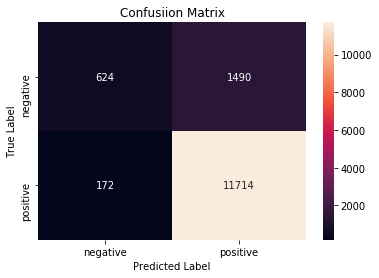

Confusion Matrix of test data 



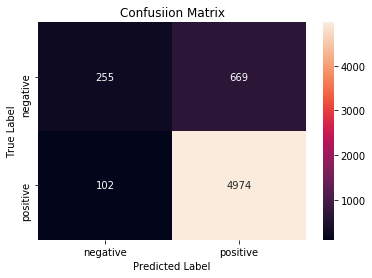

**** TEST AUC ***  0.8111437747962571
**** TRAIN AUC *****  0.8368201795964215


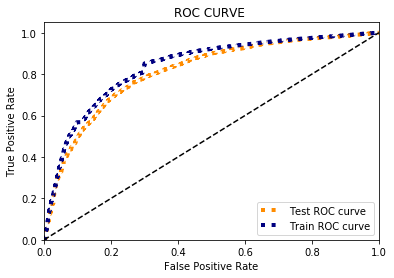

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(X_tr_vectors)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(X_test_vectors)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

###<font color='green'><b>TFIDF W2V

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names

In [ ]:
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 14000/14000 [02:51<00:00, 81.71it/s]


In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [01:20<00:00, 74.41it/s]


In [ ]:
from sklearn import svm
from sklearn.svm import SVC
Cs = [2**-1, 2**1, 2**3, 2**5, 2**7]
gammas = [ 2**-3,  2**-1,2**1, 2**3]

param_grid = {'C': Cs, 'gamma' : gammas}
print("parameters are ",param_grid)
clf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, scoring='roc_auc', cv=3, return_train_score=True)
clf.fit(tfidf_sent_vectors_tr, y_tr)
clf.best_params_
print(clf.best_params_)


parameters are  {'C': [0.5, 2, 8, 32, 128], 'gamma': [0.125, 0.5, 2, 8]}
{'C': 8, 'gamma': 0.125}


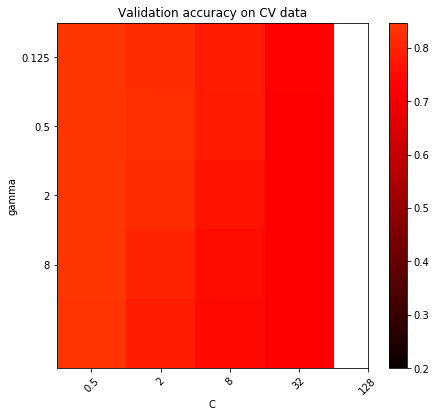

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on CV data')
plt.show()

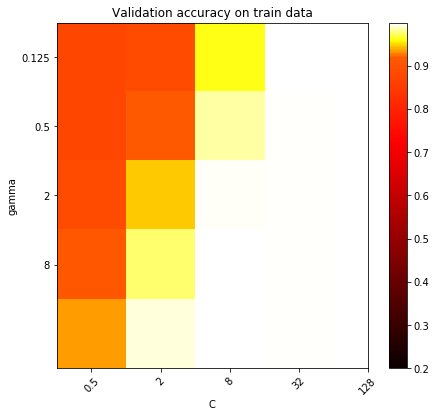

In [ ]:
scores = clf.cv_results_['mean_train_score'].reshape(
                                                     len(param_grid['C']), len(param_grid['gamma']))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=45)
plt.yticks(np.arange(len((param_grid['gamma']))), param_grid['gamma'])
plt.title('Validation accuracy on train data')
plt.show()

In [ ]:
print("\n Train Score **\n")
print(clf.cv_results_['mean_train_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))
print("\n CV Score **\n")
print(clf.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma'])))



 Train Score **

[[0.8784398  0.8909325  0.9626139  0.99911012]
 [0.87955656 0.91451429 0.9847487  0.99823373]
 [0.89177885 0.94607342 0.99762608 0.99848142]
 [0.9126776  0.97586044 0.99902516 0.99848142]
 [0.93561127 0.99327049 0.99912104 0.99848142]]

 CV Score **

[[0.84432515 0.82276677 0.7856274  0.73305413]
 [0.84482085 0.82571596 0.78141263 0.72814991]
 [0.84678469 0.8192188  0.76719897 0.72657032]
 [0.84534567 0.80526761 0.75178402 0.72657032]
 [0.83860077 0.78528598 0.74909123 0.72657032]]


In [ ]:
svc = svm.SVC(kernel='rbf', C =8 , gamma = 0.125, probability=True )
svc.fit(tfidf_sent_vectors_tr,y_tr)

SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.125, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Confusion Matrix of train data 



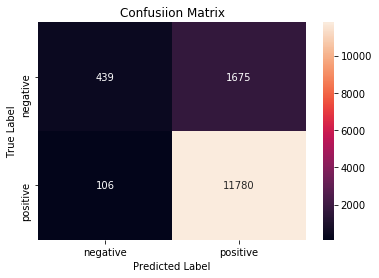

Confusion Matrix of test data 



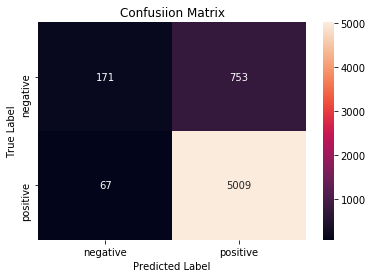

**** TEST AUC ***  0.803901050354951
**** TRAIN AUC *****  0.8370366598421364


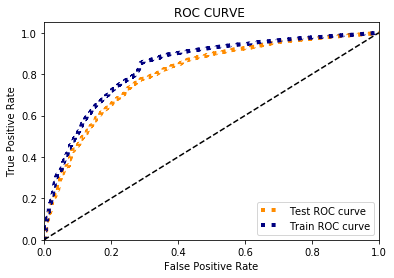

In [ ]:
print("Confusion Matrix of train data \n")
predict = svc.predict(tfidf_sent_vectors_tr)
cm = metrics.confusion_matrix(y_tr, predict)
ConfusionMatrixPrint(cm)
print("Confusion Matrix of test data \n")
predict = svc.predict(tfidf_sent_vectors_test)
cm = metrics.confusion_matrix(y_test, predict)
ConfusionMatrixPrint(cm)
y_cv_predict = np.array(svc.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(svc.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>SUMMARY </b></font>

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("S.NO",[1,2,3,4,5,6,7,8])
x.add_column("Model Description",["linear SVM on Bow"," linear SVM on Tf-IDF",\
                                  " linear SVM on Avg W2V", " linear SVM on TF-IDF w2v",\
                                  "RBF SVM on BoW"," RBF SVM on TF-IDF"," RBF SVM on Avg W2V",\
                                  " RBF SVM on TFIDF W2V"])
x.add_column("Hyperparameter ",["L2 with 0.001" ,"L2 with 0.0001","L2 with 0.001","L2 with 0.01",\
                                "C:2 and gamma 0.125","C:8 and gamma 2",\
                                "C:8 and gamma 0.125","C:8 and gamma 0.125" ])
x.add_column("Test AUC",["76.90" ,"85.60","83.28","82.14","78.59","81.62",
                         "81.11","80.39" ])
print(x)

+------+---------------------------+---------------------+----------+
| S.NO |     Model Description     |   Hyperparameter    | Test AUC |
+------+---------------------------+---------------------+----------+
|  1   |     linear SVM on Bow     |    L2 with 0.001    |  76.90   |
|  2   |    linear SVM on Tf-IDF   |    L2 with 0.0001   |  85.60   |
|  3   |    linear SVM on Avg W2V  |    L2 with 0.001    |  83.28   |
|  4   |  linear SVM on TF-IDF w2v |     L2 with 0.01    |  82.14   |
|  5   |       RBF SVM on BoW      | C:2 and gamma 0.125 |  78.59   |
|  6   |      RBF SVM on TF-IDF    |   C:8 and gamma 2   |  81.62   |
|  7   |     RBF SVM on Avg W2V    | C:8 and gamma 0.125 |  81.11   |
|  8   |    RBF SVM on TFIDF W2V   | C:8 and gamma 0.125 |  80.39   |
+------+---------------------------+---------------------+----------+
